# IMDB

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.text import *
import warnings
warnings.filterwarnings('ignore')

## Language model

Set the batch size


In [ ]:
bs=12

Grab the full the dataset



In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README')]

In [ ]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

Use the pretrained [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset) model then fine-tune it using the imdb dataset. For training this we will utilize all of the training data(train, test, unsup)

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,""" xxup schindler xxup 's xxup list . "" xxmaj if you wanted a film like "" a xxmaj room xxmaj with a xxmaj view "" then you would not be looking at xxmaj beach xxmaj babes from xxmaj beyond . xxmaj but if you are looking for a good xxmaj babes in xxmaj bikini movie with almost no plot , this is the one for you . xxmaj this"
1,"always wet and not much had to be done to show them that way . \n \n xxmaj when we first meet xxmaj tony , he is playing cards . xxmaj tony appears to be in bad health ; he coughs all the time and sweats profusely . xxmaj after losing all his money , he goes to see xxmaj jo , the xxmaj swede , who tells him"
2,"very few redeeming qualities . xxmaj can be fun but overall it is n't a great movie and is certainly one of xxmaj wayne 's weaker outings . xxbos i found xxmaj super xxmaj troopers only mildly amusing at best ( seemed like a glorified xxmaj police xxmaj academy ripoff to me ) , and i rented this movie in hopes of it being better . xxmaj it was n't"
3,"watch the rest of the movie . xxmaj it has one slightly sick scene in it ( trust me , it 's not very pleasant ) but apart from that this is a great movie . i rate this movie an 7 / 8 for comedy , 10 / 10 for sexual content and 10 / 10 for the plot . please if your a fan of xxmaj american xxmaj"
4,"xxmaj bourne xxmaj supremacy arrived i thought it was a better movie than xxmaj identity but still did n't think it was as good as i expected it to be judging by the trailers . xxmaj over the past two years i had been told numerous times that the xxmaj bourne movies were amazing , many a time i had to bite my tongue and not say what i really"


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


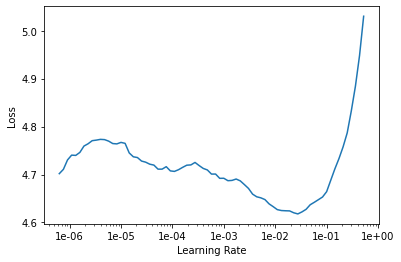

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.232034,4.060273,0.292894


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

Unfreeze the layers and fine-tune it further

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.958489,3.885153,0.310139
2,3.871605,3.814774,0.319821
3,3.804589,3.767966,0.325793
4,3.771248,3.729666,0.330175
5,3.677534,3.699244,0.333532
6,3.644140,3.674071,0.336564
7,3.603597,3.655099,0.338747
8,3.524271,3.641979,0.340568
9,3.505476,3.636194,0.341246
10,3.461232,3.635963,0.341371


In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


In [ ]:
learn.save_encoder('fine_tuned_enc') # save the language model's encoder which we will use to classify text

## Classifier

Create a new dataset the grabs the labelled data

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))